# End-to-End Data Analytics & Modeling Project

## Project Overview

This notebook presents a complete data science workflow — from raw review ingestion to exploratory analysis, sentiment labeling, and visual insight generation — using the **Amazon Reviews’23** dataset collected by the McAuley Lab.

The objective is to explore user review behavior, sentiment trends, and the role of product metadata in shaping consumer trust, feedback quality, and perceived helpfulness. We aim to surface patterns that can inform **fairness-aware product recommendations** and reveal potential biases across user interactions and product categories.

---

## About the Dataset

The **Amazon Reviews’23** dataset is a large-scale benchmark featuring:

- **571M+ user reviews** from May 1996 to September 2023  
- **48M+ unique products** and detailed metadata (title, price, features, images, etc.)
- Fine-grained review-level fields: `rating`, `review text`, `verified_purchase`, `helpful_votes`, and `timestamp`
- **Rich item metadata**: product descriptions, categories, store info, bundles, and image links

Dataset citation (Hou et al., 2024):  
**Bridging Language and Items for Retrieval and Recommendation**  
[arXiv preprint arXiv:2403.03952](https://arxiv.org/abs/2403.03952)

[Project Page](https://huggingface.co/datasets/mcauley-lab/Amazon-Reviews-2023)


## Project Pipeline

> This notebook is structured into the following key stages:

1. **Data Preparation & Exploration**  
   Load the dataset into a database, clean it, handle missing values, fix data types, remove outliers, and explore basic stats and distributions.

2. **QA & Visualization**  
   Ask key questions about the data, create visualizations to answer them, and explore relationships between variables using charts and graphs.

3. **Predictive Modeling**  
   Build a simple model to make predictions, compare its performance to a baseline, and explore ways to improve results.

4. **Final Presentation & Interpretation**  
   Summarize the data cleaning steps, share top insights, review model performance, and explain the business value of the results.





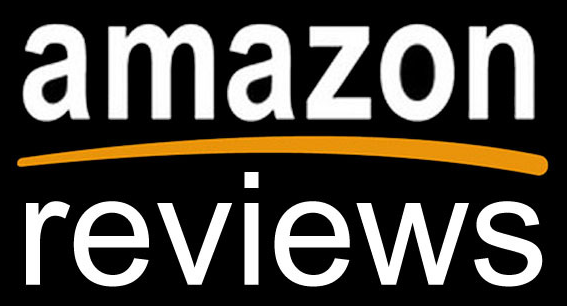


## **Import All Necessary Libraries**

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

nltk.download('wordnet')
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## **1. Data Preparation & Exploration**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving newdata.xlsx to newdata.xlsx


In [ ]:
from sqlalchemy import create_engine
df = pd.read_excel('newdata.xlsx')
engine = create_engine('sqlite:///newdata.db')


In [ ]:
df

,rating,text,verified_purchase,helpful_vote
0,5,This tablet is everything and more than I expe...,True,0
1,5,My son absolutely loved these!!,True,0
2,5,My sister-in-law loves this for Christmas! She...,True,0
3,5,Fits perfectly on my iPad Air first generation...,True,0
4,2,My projector's power button stopped working af...,True,0
...,...,...,...,...
299994,5,This is a great product to reduce heat and wil...,True,0
299995,5,The best case you will ever buy.,True,0
299996,5,The best SSD you will get on the market.,True,0
299997,5,This hard drive is fast. What does this mean f...,True,0


In [ ]:
df.to_sql('newdata.xslx', engine, if_exists='replace', index=False)

299999

In [ ]:
df_db = pd.read_sql("SELECT * FROM 'newdata.xslx'", engine)
df_db


,rating,text,verified_purchase,helpful_vote
0,5,This tablet is everything and more than I expe...,1,0
1,5,My son absolutely loved these!!,1,0
2,5,My sister-in-law loves this for Christmas! She...,1,0
3,5,Fits perfectly on my iPad Air first generation...,1,0
4,2,My projector's power button stopped working af...,1,0
...,...,...,...,...
299994,5,This is a great product to reduce heat and wil...,1,0
299995,5,The best case you will ever buy.,1,0
299996,5,The best SSD you will get on the market.,1,0
299997,5,This hard drive is fast. What does this mean f...,1,0


In [ ]:
df_db['rating'] = df_db['rating'].astype(float)
df_db['verified_purchase'] = df_db['verified_purchase'].astype(bool)


In [ ]:
df_db.isna().sum()

,0
rating,0
text,99
verified_purchase,0
helpful_vote,0


In [ ]:
df_db.dropna(axis=0,inplace=True)


In [ ]:
def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df_db['sentiment'] = df_db['rating'].apply(label_sentiment)

df_db['review_length'] = df_db['text'].astype(str).apply(lambda x: len(x.split()))

df_db.to_sql('newdata.xslx', engine, if_exists='replace', index=False)


299900

In [ ]:
df_db

,rating,text,verified_purchase,helpful_vote,sentiment,review_length
0,5.0,This tablet is everything and more than I expe...,True,0,positive,45
1,5.0,My son absolutely loved these!!,True,0,positive,5
2,5.0,My sister-in-law loves this for Christmas! She...,True,0,positive,28
3,5.0,Fits perfectly on my iPad Air first generation...,True,0,positive,25
4,2.0,My projector's power button stopped working af...,True,0,negative,21
...,...,...,...,...,...,...
299994,5.0,This is a great product to reduce heat and wil...,True,0,positive,15
299995,5.0,The best case you will ever buy.,True,0,positive,7
299996,5.0,The best SSD you will get on the market.,True,0,positive,9
299997,5.0,This hard drive is fast. What does this mean f...,True,0,positive,64


In [ ]:
df_db.dtypes

,0
rating,float64
text,object
verified_purchase,bool
helpful_vote,int64
sentiment,object
review_length,int64


In [ ]:
df_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299900 entries, 0 to 299998
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             299900 non-null  float64
 1   text               299900 non-null  object 
 2   verified_purchase  299900 non-null  bool   
 3   helpful_vote       299900 non-null  int64  
 4   sentiment          299900 non-null  object 
 5   review_length      299900 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 14.0+ MB


In [ ]:
df_db["sentiment"].value_counts()

,count
sentiment,
positive,228886
negative,51188
neutral,19826


In [ ]:
df_db.duplicated().sum()


np.int64(22680)

In [ ]:
df_db.drop_duplicates(inplace=True)

In [ ]:
df_db.describe()

,rating,helpful_vote,review_length
count,277220.000000,277220.000000,277220.000000
mean,4.057918,1.045902,45.673119
std,1.428004,12.465189,74.164119
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,11.000000
50%,5.000000,0.000000,24.000000
75%,5.000000,0.000000,52.000000
max,5.000000,2784.000000,3209.000000


In [ ]:
df_db["sentiment"].value_counts()

,count
sentiment,
positive,207463
negative,50316
neutral,19441


In [ ]:
positive_df = df_db[df_db["sentiment"] == "positive"]
# Calculate the number of duplicates in the positive_df
num_duplicates = positive_df.duplicated().sum()
print(f"Number of duplicates in positive sentiment: {num_duplicates}")
# Drop duplicates in the positive_df
positive_df = positive_df.drop_duplicates()
# Filter the DataFrame for non-positive sentiments
non_positive_df = df_db[df_db["sentiment"] != "positive"]
df_db = pd.concat([positive_df, non_positive_df])
df_db = df_db.reset_index(drop=True)

Number of duplicates in positive sentiment: 0


In [ ]:
df_db["sentiment"].value_counts()

,count
sentiment,
positive,207463
negative,50316
neutral,19441


In [ ]:
df_db.groupby('sentiment')['helpful_vote'].mean()

,helpful_vote
sentiment,
negative,1.507055
neutral,1.029628
positive,0.935584


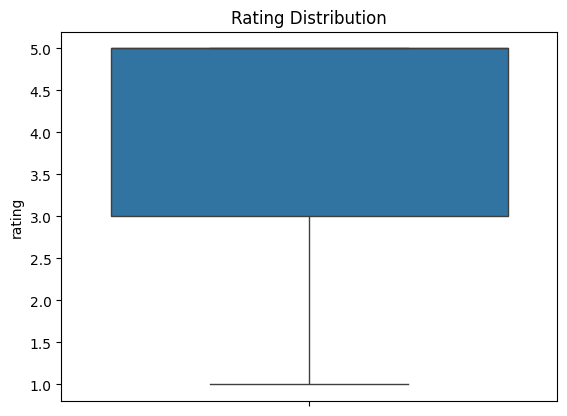

In [ ]:
sns.boxplot(df_db['rating'])
plt.title("Rating Distribution")
plt.show()

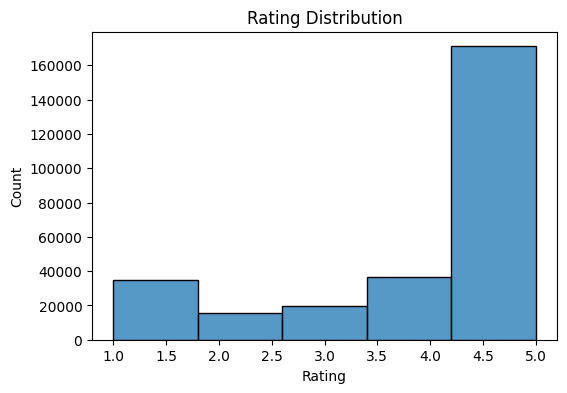

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df_db['rating'], bins=5, kde=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

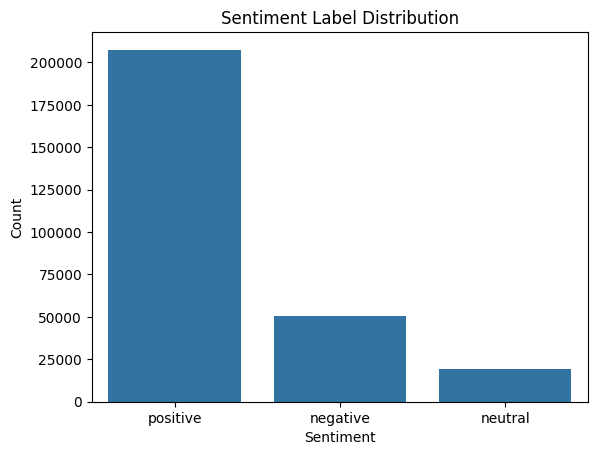

In [ ]:
sns.countplot(x='sentiment', data=df_db)
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

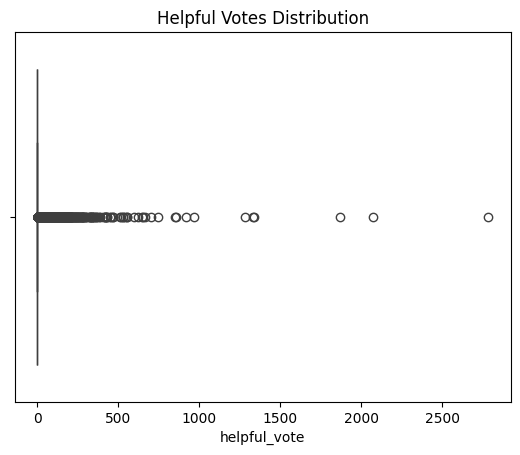

In [ ]:
sns.boxplot(x=df_db['helpful_vote'])
plt.title("Helpful Votes Distribution")
plt.show()

### **Dealing with outliers**

In [ ]:
out_list = []

for i in ['rating', 'helpful_vote', 'review_length']:
    Q1 = df_db[i].quantile(0.25)
    Q3 = df_db[i].quantile(0.75)
    IQR = Q3 - Q1
    up = Q3 + 1.5 * IQR
    low = Q1 - 1.5 * IQR

    if (df_db.loc[(df_db[i] > up) | (df_db[i] < low)]).any(axis=None):
        print(i, "yes")
        out_list.append(i)  # Add the column name to out_list
    else:
        print(i, "no")

print("Columns with outliers:", out_list)

rating no
helpful_vote yes
review_length yes
Columns with outliers: ['helpful_vote', 'review_length']


In [ ]:
for i in df_db.loc[:,out_list]:
    Q1 = df_db[i].quantile(0.25)
    Q3 = df_db[i].quantile(0.75)
    IQR = Q3 - Q1
    up_lim = Q3 + 1.5 * IQR
    low_lim = Q1 - 1.5 * IQR
    df_db.loc[df_db[i] > up_lim,i] = up_lim
    df_db.loc[df_db[i] < low_lim,i] = low_lim
for i in df_db.loc[:,out_list]:
    Q1 = df_db[i].quantile(0.25)
    Q3 = df_db[i].quantile(0.75)
    IQR = Q3-Q1
    up = Q3 + 1.5*IQR
    low = Q1 - 1.5*IQR

    if df_db[(df_db[i] > up) | (df_db[i] < low)].any(axis=None):
        print(i,"yes")
    else:
        print(i, "no")

helpful_vote no
review_length no


<ipython-input-27-c0f14f64e9af>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '113.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_db.loc[df_db[i] > up_lim,i] = up_lim


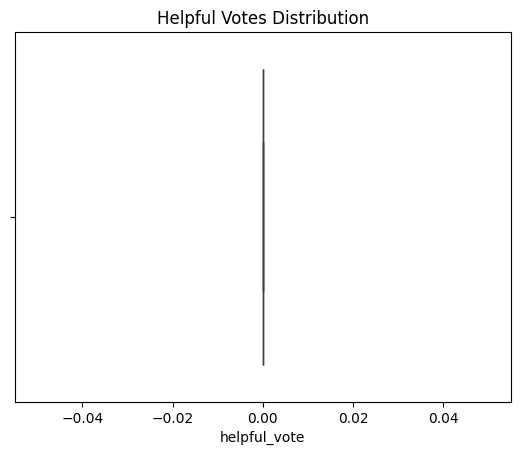

In [ ]:
sns.boxplot(x=df_db['helpful_vote'])
plt.title("Helpful Votes Distribution")
plt.show()

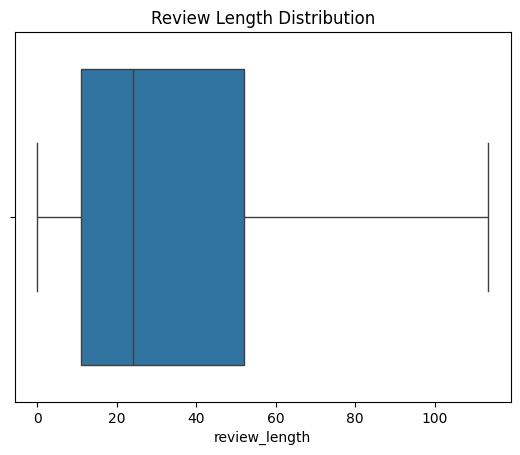

In [ ]:
sns.boxplot(x=df_db['review_length'])
plt.title("Review Length Distribution")
plt.show()

In [ ]:
all_text = ' '.join(df['text'].astype(str).tolist())

words = re.findall(r'\b\w+\b', all_text.lower())
common_words = Counter(words).most_common(20)


for word, count in common_words:
    print(f'{word}: {count}')

the: 625407
i: 437958
and: 359481
it: 357139
to: 347935
a: 303478
is: 198683
for: 187494
this: 173767
my: 164559
of: 154039
br: 152987
in: 123725
with: 122628
that: 115530
on: 111383
not: 99629
but: 99098
you: 94989
have: 94262


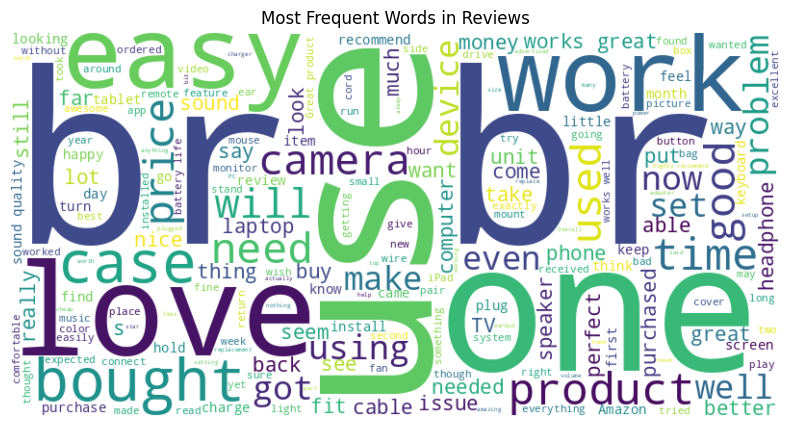

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Reviews")
plt.show()


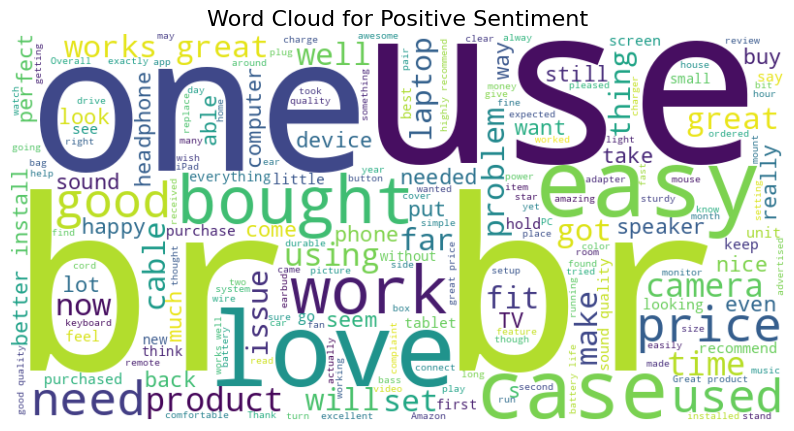

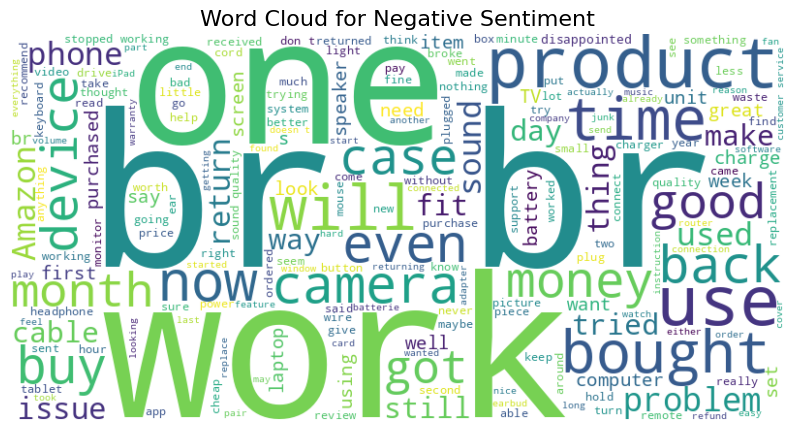

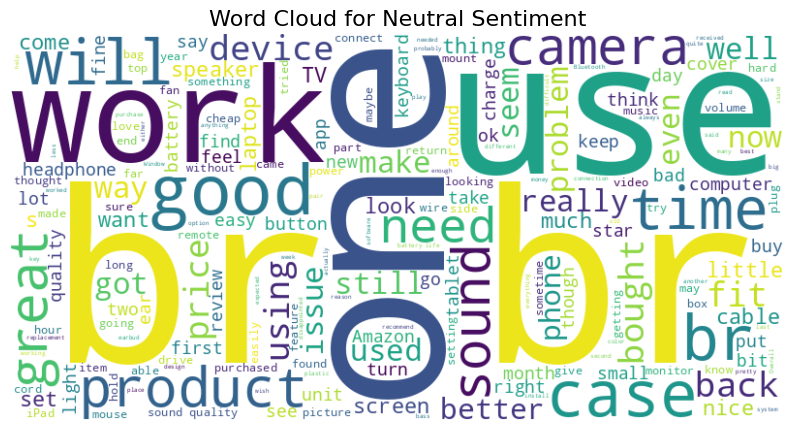

In [ ]:
# Function to generate a word cloud
def generate_word_cloud(data, sentiment):
    text = ' '.join(data[data['sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {sentiment.capitalize()} Sentiment", fontsize=16)
    plt.axis('off')
    plt.show()
# Generate word clouds for each sentiment
for sentiment in df_db['sentiment'].unique():
    generate_word_cloud(df_db, sentiment)

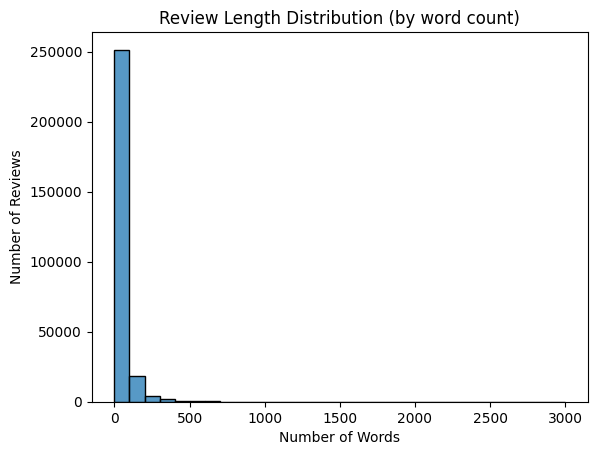

In [ ]:
df_db['review_length'] = df['text'].astype(str).apply(lambda x: len(x.split()))

sns.histplot(df_db['review_length'], bins=30)
plt.title('Review Length Distribution (by word count)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.show()


In [ ]:
# Saving Cleaned Data into a CSV file
df_db.to_csv("cleaned_reviews.csv", index=False)

## **2. QA & Visualization**

### **Q1.What is the distribution of ratings?**

<ipython-input-47-d0becdfa56cc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='crest')


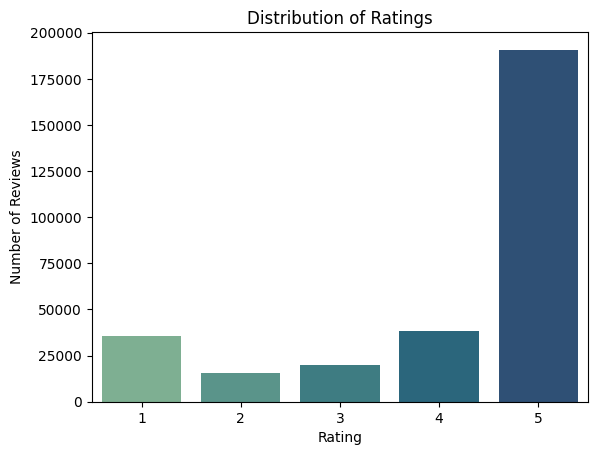

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='rating', data=df, palette='crest')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()


### **Q2. What is the relationship between the rating given and the number of helpful votes a review receives?**

In [ ]:
q1_sql = """
SELECT rating, helpful_vote
FROM 'newdata.xslx'

"""
q1_df = pd.read_sql(q1_sql, engine)
q1_df

,rating,helpful_vote
0,5,0
1,5,0
2,5,0
3,5,0
4,2,0
...,...,...
299895,5,0
299896,5,0
299897,5,0
299898,5,0


In [ ]:
correlation = q1_df[['rating', 'helpful_vote']].corr()
print(correlation)

               rating  helpful_vote
rating        1.00000      -0.02193
helpful_vote -0.02193       1.00000


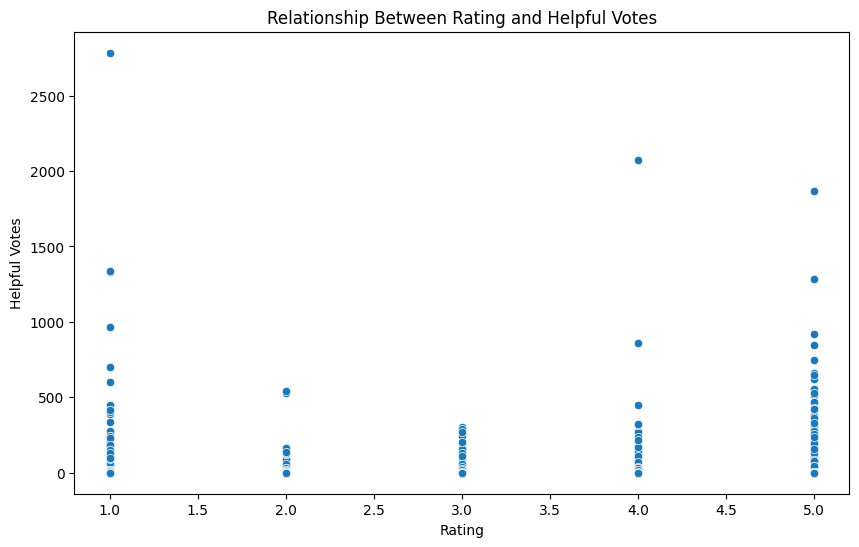

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='helpful_vote', data=q1_df)
plt.title('Relationship Between Rating and Helpful Votes')
plt.xlabel('Rating')
plt.ylabel('Helpful Votes')
plt.show()

### **Q3.How does review sentiment correlate with star ratings and helpful votes?**

In [ ]:
q2_sql = """
SELECT sentiment, AVG(rating) AS avg_rating, AVG(helpful_vote) AS avg_helpful
FROM 'newdata.xslx'
GROUP BY sentiment
"""
q2_df = pd.read_sql(q2_sql, engine)
q2_df


,sentiment,avg_rating,avg_helpful
0,negative,1.304329,1.492322
1,neutral,3.000000,1.016544
2,positive,4.833092,0.855649


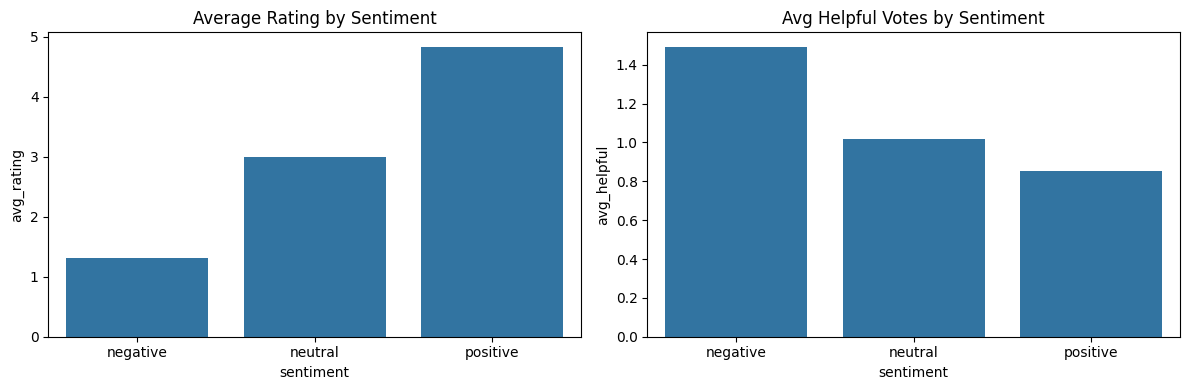

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=q2_df, x='sentiment', y='avg_rating', order=['negative', 'neutral', 'positive'], ax=ax[0])
ax[0].set_title('Average Rating by Sentiment')
sns.barplot(data=q2_df, x='sentiment', y='avg_helpful', order=['negative', 'neutral', 'positive'], ax=ax[1])
ax[1].set_title('Avg Helpful Votes by Sentiment')
plt.tight_layout()
plt.show()


### **Q4. Do longer reviews tend to be rated more helpful by users?**

In [ ]:
q3_sql = """
SELECT review_length, helpful_vote
FROM 'newdata.xslx'
"""
q3_df = pd.read_sql(q3_sql, engine)
q3_df

,review_length,helpful_vote
0,45,0
1,5,0
2,28,0
3,25,0
4,21,0
...,...,...
299895,15,0
299896,7,0
299897,9,0
299898,64,0


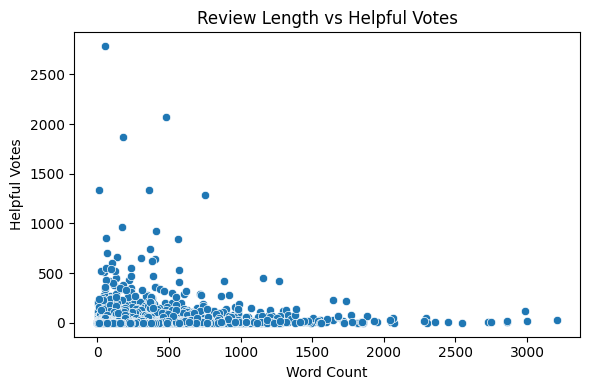

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=q3_df, x='review_length', y='helpful_vote')
plt.title('Review Length vs Helpful Votes')
plt.xlabel('Word Count')
plt.ylabel('Helpful Votes')
plt.tight_layout()
plt.show()


In [ ]:
print(q3_df[['review_length', 'helpful_vote']].corr())


               review_length  helpful_vote
review_length       1.000000      0.166195
helpful_vote        0.166195      1.000000


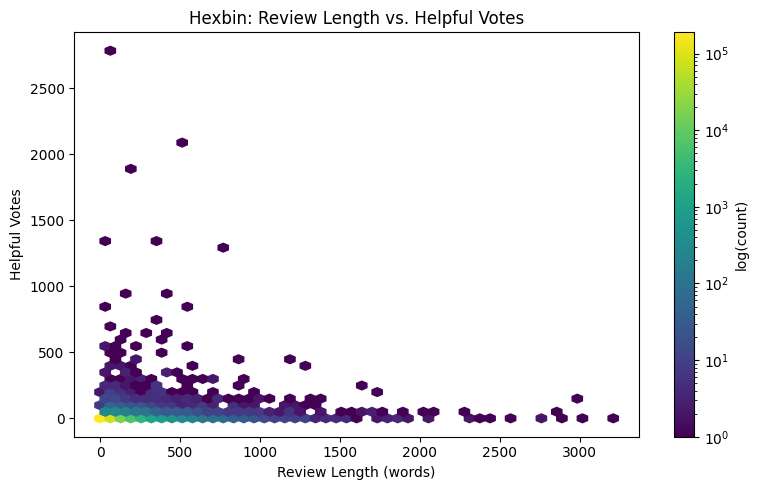

In [ ]:
plt.figure(figsize=(8, 5))
plt.hexbin(q3_df['review_length'], q3_df['helpful_vote'], gridsize=50, cmap='viridis', bins='log')
plt.colorbar(label='log(count)')
plt.xlabel('Review Length (words)')
plt.ylabel('Helpful Votes')
plt.title('Hexbin: Review Length vs. Helpful Votes')
plt.tight_layout()
plt.show()


### **Q5. Are short reviews more likely to be neutral or negative in sentiment**

In [ ]:
q4_sql = """
SELECT sentiment, COUNT(*) AS count
FROM 'newdata.xslx'
WHERE review_length <= 5
GROUP BY sentiment
"""
q4_df = pd.read_sql(q4_sql, engine)
q4_df

,sentiment,count
0,negative,3694
1,neutral,1432
2,positive,45383


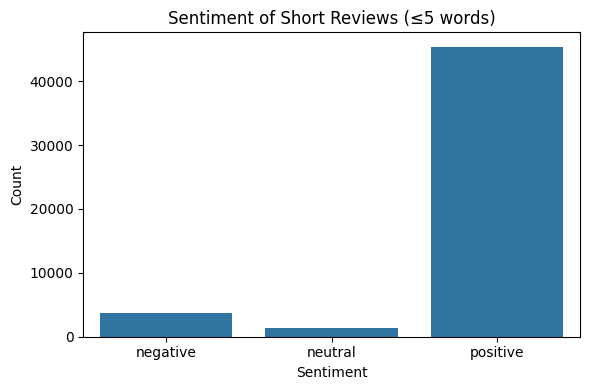

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(data=q4_df, x='sentiment', y='count', order=['negative', 'neutral', 'positive'])
plt.title('Sentiment of Short Reviews (≤5 words)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


### **Q6. Do verified purchase reviews tend to be longer than unverified reviews?**

In [ ]:
q5_sql = """
SELECT verified_purchase, LENGTH(text) AS review_length
FROM 'newdata.xslx'
"""
q5_df = pd.read_sql(q5_sql, engine)
df_db.groupby('verified_purchase')['review_length'].mean()

q5_df

,verified_purchase,review_length
0,1,258
1,1,31
2,1,171
3,1,124
4,1,129
...,...,...
299895,1,72
299896,1,32
299897,1,40
299898,1,351


In [ ]:
average_lengths = q5_df.groupby('verified_purchase')['review_length'].mean()
print(average_lengths)

verified_purchase
0    499.219600
1    211.841345
Name: review_length, dtype: float64


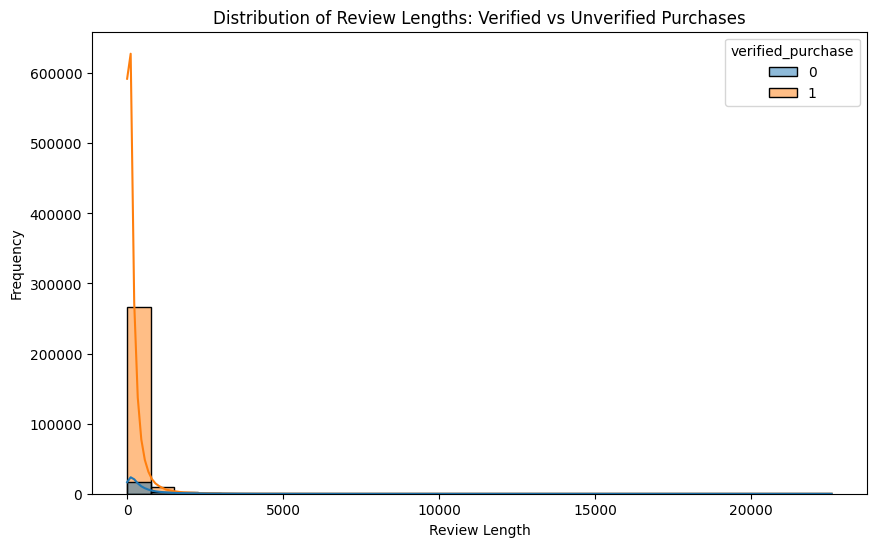

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=q5_df, x='review_length', hue='verified_purchase', kde=True, bins=30)
plt.title('Distribution of Review Lengths: Verified vs Unverified Purchases')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


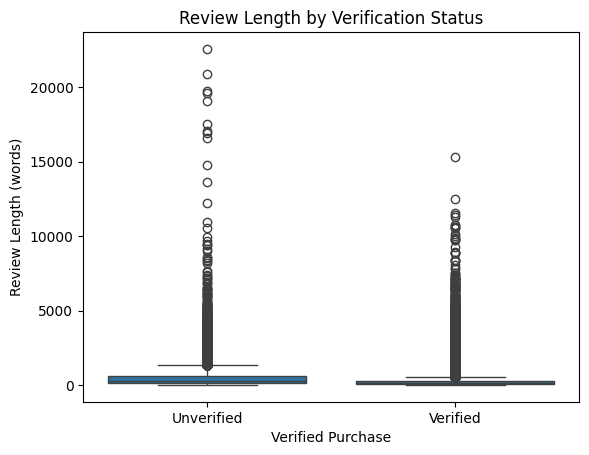

In [ ]:
sns.boxplot(x='verified_purchase', y='review_length', data=q5_df)
plt.xticks([0,1], ['Unverified', 'Verified'])
plt.title('Review Length by Verification Status')
plt.xlabel('Verified Purchase')
plt.ylabel('Review Length (words)')
plt.show()


### **Q7. How does the helpfulness of a review vary by both sentiment and rating category?**

In [ ]:
q1_sql = """
SELECT
    sentiment,
    rating,
    AVG(helpful_vote) AS avg_helpful_votes,
    COUNT(*) AS num_reviews
FROM 'newdata.xslx'
GROUP BY sentiment, rating
"""
q1_df = pd.read_sql(q1_sql, engine)
q1_df

,sentiment,rating,avg_helpful_votes,num_reviews
0,negative,1.0,1.687251,35610
1,negative,2.0,1.046733,15578
2,neutral,3.0,1.016544,19826
3,positive,4.0,1.083344,38203
4,positive,5.0,0.810030,190683


In [ ]:
# Pivot for comparison
pivot = q1_df.pivot_table(index='sentiment', columns='rating', values='avg_helpful_votes')
print("Avg Helpful Votes by Sentiment and Rating:")
print(pivot)

Avg Helpful Votes by Sentiment and Rating:
rating          1.0       2.0       3.0       4.0      5.0
sentiment                                                 
negative   1.687251  1.046733       NaN       NaN      NaN
neutral         NaN       NaN  1.016544       NaN      NaN
positive        NaN       NaN       NaN  1.083344  0.81003


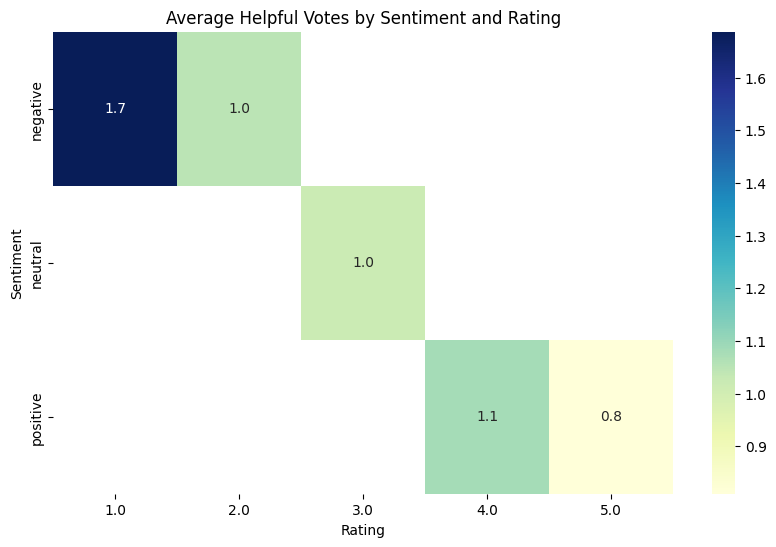

In [ ]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title('Average Helpful Votes by Sentiment and Rating')
plt.xlabel('Rating')
plt.ylabel('Sentiment')
plt.show()

### **Q8. Is there a statistically meaningful correlation between rating, review length, and helpfulness?**

In [ ]:
q7_sql = """
SELECT rating, review_length, helpful_vote
FROM 'newdata.xslx'
WHERE helpful_vote IS NOT NULL
"""
q7_df = pd.read_sql(q7_sql, engine)
q7_df

,rating,review_length,helpful_vote
0,5.0,45,0
1,5.0,5,0
2,5.0,28,0
3,5.0,25,0
4,2.0,21,0
...,...,...,...
299895,5.0,15,0
299896,5.0,7,0
299897,5.0,9,0
299898,5.0,64,0


In [ ]:
# Correlation matrix
correlation = q7_df[['rating', 'review_length', 'helpful_vote']].corr()
print("Correlation Matrix:\n", correlation)

Correlation Matrix:
                  rating  review_length  helpful_vote
rating         1.000000      -0.108693     -0.021930
review_length -0.108693       1.000000      0.166195
helpful_vote  -0.021930       0.166195      1.000000


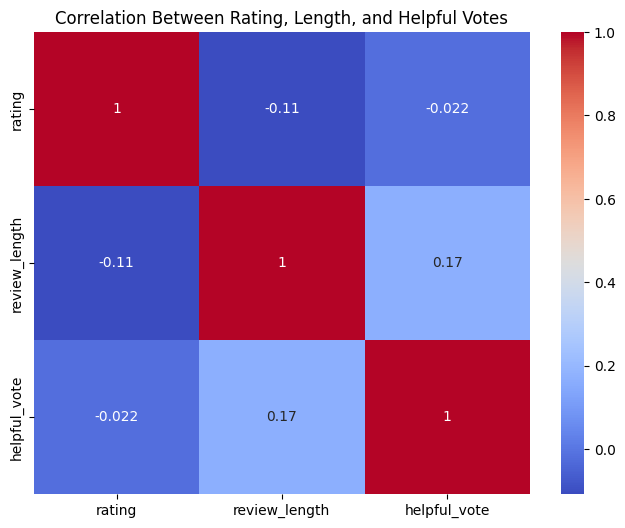

In [ ]:
# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Between Rating, Length, and Helpful Votes')
plt.show()

### **Q9. Are verified purchases with high ratings more likely to be considered helpful?**

In [ ]:
q8_sql = """
SELECT
    verified_purchase,
    CASE
        WHEN rating >= 4 THEN 'High'
        WHEN rating = 3 THEN 'Neutral'
        ELSE 'Low'
    END AS rating_category,
    AVG(helpful_vote) AS avg_helpful
FROM 'newdata.xslx'
WHERE helpful_vote IS NOT NULL
GROUP BY verified_purchase, rating_category
"""
q8_df = pd.read_sql(q8_sql, engine)
q8_df

,verified_purchase,rating_category,avg_helpful
0,0,High,1.989881
1,0,Low,2.049566
2,0,Neutral,2.051480
3,1,High,0.785446
4,1,Low,1.431142
5,1,Neutral,0.928525


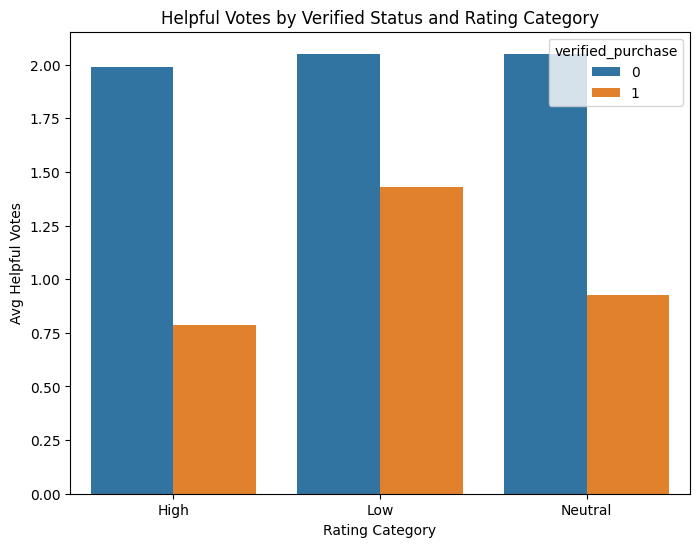

In [ ]:
# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(x='rating_category', y='avg_helpful', hue='verified_purchase', data=q8_df)
plt.title('Helpful Votes by Verified Status and Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Avg Helpful Votes')
plt.show()

### **Q10. Which review lengths are associated with the highest average rating per sentiment group?**

In [ ]:
q9_sql = """
SELECT
    sentiment,
    CASE
        WHEN review_length < 50 THEN 'Short'
        WHEN review_length BETWEEN 50 AND 150 THEN 'Medium'
        ELSE 'Long'
    END AS review_bin,
    AVG(rating) AS avg_rating
FROM 'newdata.xslx'
GROUP BY sentiment, review_bin
"""
q9_df = pd.read_sql(q9_sql, engine)
q9_df

,sentiment,review_bin,avg_rating
0,negative,Long,1.408729
1,negative,Medium,1.344415
2,negative,Short,1.277034
3,neutral,Long,3.000000
4,neutral,Medium,3.000000
5,neutral,Short,3.000000
6,positive,Long,4.670106
7,positive,Medium,4.755835
8,positive,Short,4.858422


In [ ]:
# Pivot and plot
pivot = q9_df.pivot_table(index='sentiment', columns='review_bin', values='avg_rating')
print(pivot)

review_bin      Long    Medium     Short
sentiment                               
negative    1.408729  1.344415  1.277034
neutral     3.000000  3.000000  3.000000
positive    4.670106  4.755835  4.858422


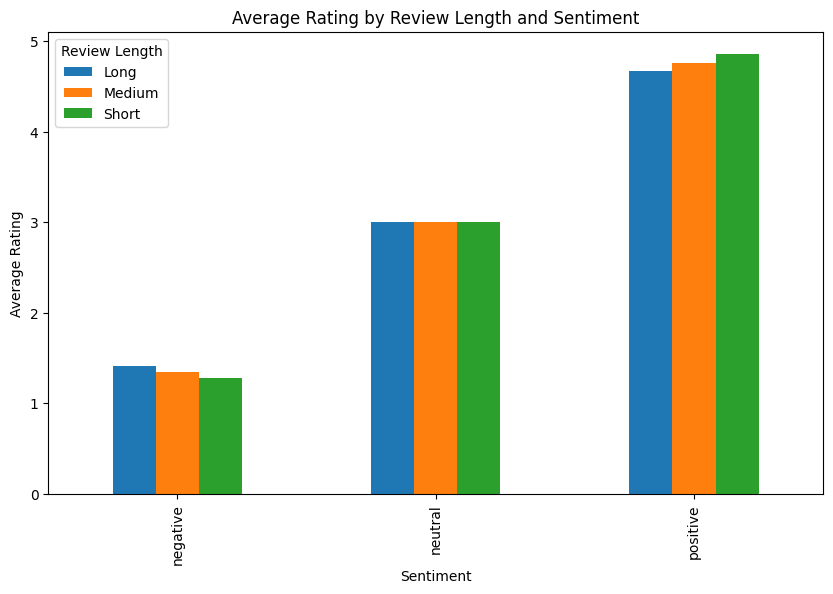

In [ ]:
pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Average Rating by Review Length and Sentiment')
plt.ylabel('Average Rating')
plt.xlabel('Sentiment')
plt.legend(title='Review Length')
plt.show()

### **Q11. What proportion of extremely helpful reviews (e.g., helpful_vote > 10) come from verified purchases?**

In [ ]:
q10_sql = """
SELECT
    verified_purchase,
    COUNT(*) AS total_reviews,
    SUM(CASE WHEN helpful_vote > 10 THEN 1 ELSE 0 END) AS highly_helpful_reviews
FROM 'newdata.xslx'
GROUP BY verified_purchase
"""
q10_df = pd.read_sql(q10_sql, engine)
q10_df['proportion_high_helpful'] = q10_df['highly_helpful_reviews'] / q10_df['total_reviews']
q10_df

,verified_purchase,total_reviews,highly_helpful_reviews,proportion_high_helpful
0,0,19959,765,0.038329
1,1,279941,3547,0.012671


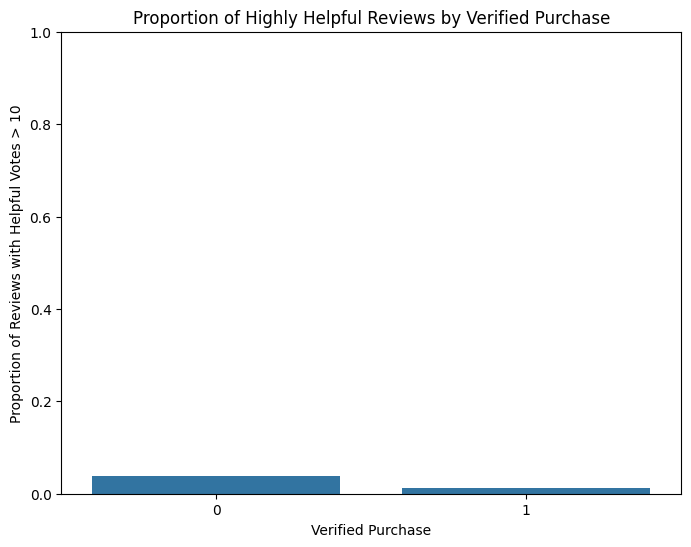

In [ ]:
# Bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='verified_purchase', y='proportion_high_helpful', data=q10_df)
plt.title('Proportion of Highly Helpful Reviews by Verified Purchase')
plt.ylabel('Proportion of Reviews with Helpful Votes > 10')
plt.xlabel('Verified Purchase')
plt.ylim(0, 1)
plt.show()

## **3. Modeling**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving cleaned_reviews.csv to cleaned_reviews (1).csv


In [5]:
df = pd.read_csv('cleaned_reviews.csv')

In [6]:
df["sentiment"].value_counts()

,count
sentiment,
positive,207463
negative,50316
neutral,19441


### **Lowercase Text**


In [7]:
df['text'] = df['text'].str.lower()
print (df['text'].head(5))
df['text'][50]

0    this tablet is everything and more than i expe...
1                      my son absolutely loved these!!
2    my sister-in-law loves this for christmas! she...
3    fits perfectly on my ipad air first generation...
4    this may be more of a speaker issue than the a...
Name: text, dtype: object


'i have bought a lot of earbuds.i mean a whole lot.just got this one a few days ago.amazed at the battery life.18 hours unbelievable.just placed another order for one.if there was a higher rating i would give it.'

### **Clean Text**


In [8]:
# Text cleaning function
import re
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply cleaning to the text column
df['text'] = df['text'].apply(clean_text)
print (df['text'][50])

i have bought a lot of earbudsi mean a whole lotjust got this one a few days agoamazed at the battery life hours unbelievablejust placed another order for oneif there was a higher rating i would give it


### **Tokenization**

In [9]:
from nltk.tokenize import word_tokenize

# Apply tokenization to each row in the 'text' column
df['text'] = df['text'].apply(lambda x: word_tokenize(str(x)))
print(type(df['text'][50]))  # Check the type of the first element
print(df['text'][50])        # Inspect the content of the first element

<class 'list'>
['i', 'have', 'bought', 'a', 'lot', 'of', 'earbudsi', 'mean', 'a', 'whole', 'lotjust', 'got', 'this', 'one', 'a', 'few', 'days', 'agoamazed', 'at', 'the', 'battery', 'life', 'hours', 'unbelievablejust', 'placed', 'another', 'order', 'for', 'oneif', 'there', 'was', 'a', 'higher', 'rating', 'i', 'would', 'give', 'it']


In [10]:
# set() function converts the stopwords list into a set.
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['text'] = df['text'].apply(remove_stopwords)
print(df['text'][50])        # Inspect the content of the first element

['bought', 'lot', 'earbudsi', 'mean', 'whole', 'lotjust', 'got', 'one', 'days', 'agoamazed', 'battery', 'life', 'hours', 'unbelievablejust', 'placed', 'another', 'order', 'oneif', 'higher', 'rating', 'would', 'give']


In [11]:
!pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.0 MB/s eta 0:00:00


In [12]:
import contractions
def convert_to_string(x):
    if isinstance(x, list):
        return ' '.join(x)
    return x

df['text'] = df['text'].apply(convert_to_string)


# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Apply to the text column
df['text'] = df['text'].apply(expand_contractions)

# Example
print(expand_contractions("I'm learning NLP. It's awesome!"))
print(expand_contractions("It's gon na be alright!"))

I am learning NLP. It is awesome!
It is gon na be alright!


In [13]:
# Define a function to convert list to string
def tokenize_to_string(tokens):
    if isinstance(tokens, list):
        return ' '.join(map(str, tokens))
    return tokens
positive_df = df[df["sentiment"] == "positive"].copy()
positive_df = positive_df.applymap(tokenize_to_string)

# Calculate the number of duplicates in the positive_df
num_duplicates = positive_df.duplicated().sum()
print(f"Number of duplicates in positive sentiment: {num_duplicates}")
# Drop duplicates from the DataFrame where tokens are converted to strings
positive_df = positive_df.drop_duplicates()
# Filter the DataFrame for non-positive sentiments without altering it
non_positive_df = df[df["sentiment"] != "positive"]
df = pd.concat([positive_df, non_positive_df])
df = df.reset_index(drop=True)


<ipython-input-13-b648338f5b86>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  positive_df = positive_df.applymap(tokenize_to_string)


Number of duplicates in positive sentiment: 1178


In [14]:
df["sentiment"].value_counts()

,count
sentiment,
positive,206285
negative,50316
neutral,19441


In [15]:
X = df['text']         # Feature: review text
y = df['sentiment']    # Target label: sentiment


# Split data into 80% train+validation, and 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the train+validation set further into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Check the sizes of splits
print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Training set size: 176666
Validation set size: 44167
Test set size: 55209


In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [17]:
count_vectorizer = CountVectorizer(min_df = 50, #A term must appear in at least 50 documents to be considered.
                                   ngram_range = (1,2), #Specifies the range of n-grams to be extracted.
                                   strip_accents='unicode', #Removes accents from characters by converting them to their closest ASCII representation.
                                   binary=False)
# Fit and transform on training data that creates a numerical matrix based on the learned vocabulary.
X_train_count = count_vectorizer.fit_transform(X_train)

# Create a DataFrame to see the term frequencies
feature_names = count_vectorizer.get_feature_names_out()
train_counts = np.asarray(X_train_count.sum(axis=0)).flatten()

# Combine into a DataFrame
term_frequencies = pd.DataFrame({
    'term': feature_names,
    'count': train_counts
})

# Sort by descending frequency
term_frequencies = term_frequencies.sort_values(by='count', ascending=False)

# Display the most frequent terms
print(term_frequencies.head(50))


            term  count
5730         not  52832
3571       great  48335
5986         one  34403
3400        good  33806
9258         use  30118
10021      would  28839
4705        like  27172
9965       works  25232
6746     product  23032
9671        well  23007
6940     quality  22519
8118       sound  21560
9867        work  21064
3250         get  20883
2328        easy  19356
6654       price  18047
1247        case  17149
4989        love  16840
8823        time  16322
897       bought  15816
7119      really  15635
2185          do  15624
2186      do not  15621
3843        have  14429
249           am  14325
206         also  13396
2515        even  12799
5442        much  12616
1137      camera  12561
9346        used  12150
1764       could  12031
1047         buy  11995
5655        nice  11952
4818      little  11916
742       better  11790
3514         got  11574
9377       using  11405
558         back  11147
9085          tv  10960
649      battery  10909
1084       cable

In [ ]:
# Transform test data using the same vocabulary
X_test = count_vectorizer.transform(X_test)
X_val = count_vectorizer.transform(X_val)


In [18]:
from sklearn.preprocessing import MaxAbsScaler

# Initialize MaxAbsScaler
scaler = MaxAbsScaler()

# Scale the data
X_train = scaler.fit_transform(X_train_tfidf)
X_test = scaler.transform(X_test_tfidf)
X_val = scaler.transform(X_val_tfidf)

**Resampling Techniques**
1. Oversampling Minority Classes: Duplicate or synthetically generate samples for neutral and negative classes to balance the dataset (e.g., using SMOTE – Synthetic Minority Oversampling Technique).
2. Undersampling Majority Class: Randomly remove samples from the positive class to match the size of the smaller classes.

### **Undersampling**


In [19]:
train_df = pd.DataFrame({'text': X_train, 'sentiment': y_train})


# Determine the smallest class size
min_samples_train = min(train_df['sentiment'].value_counts())

positive = train_df[train_df['sentiment'] == 'positive']
neutral = train_df[train_df['sentiment'] == 'neutral']
negative = train_df[train_df['sentiment'] == 'negative']

# Undersample all classes to match the smallest class size
positive_undersampled = resample(positive,
                                 replace=False,
                                 n_samples=min_samples_train,
                                 random_state=42)

neutral_undersampled = resample(neutral,
                                replace=False,
                                n_samples=min_samples_train,
                                random_state=42)

negative_undersampled = resample(negative,
                                 replace=False,
                                 n_samples=min_samples_train,
                                 random_state=42)

# Combine all classes into a balanced DataFrame
df_balanced = pd.concat([positive_undersampled[['text', 'sentiment']], neutral_undersampled[['text', 'sentiment']], negative_undersampled[['text', 'sentiment']]])

# Shuffle the DataFrame to mix the class entries
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Display final details
print(f'The shape of the new dataframe is {df_balanced.shape}')
print(df_balanced['sentiment'].value_counts())

The shape of the new dataframe is (37410, 2)
sentiment
negative    12470
neutral     12470
positive    12470
Name: count, dtype: int64


In [20]:
df_balanced.head()

,text,sentiment
0,<Compressed Sparse Row sparse matrix of dtype ...,negative
1,<Compressed Sparse Row sparse matrix of dtype ...,neutral
2,<Compressed Sparse Row sparse matrix of dtype ...,negative
3,<Compressed Sparse Row sparse matrix of dtype ...,positive
4,<Compressed Sparse Row sparse matrix of dtype ...,neutral


In [21]:
X_train_balanced = df_balanced['text']
y_train_balanced = df_balanced['sentiment']


In [22]:
X_train_balanced.head()

,text
0,<Compressed Sparse Row sparse matrix of dtype ...
1,<Compressed Sparse Row sparse matrix of dtype ...
2,<Compressed Sparse Row sparse matrix of dtype ...
3,<Compressed Sparse Row sparse matrix of dtype ...
4,<Compressed Sparse Row sparse matrix of dtype ...


In [23]:
# Convert numpy array back to a DataFrame
y_train_balanced = pd.DataFrame(y_train_balanced, columns=['sentiment_encoded'])

# Display the first few entries
print(y_train_balanced.head())

Empty DataFrame
Columns: [sentiment_encoded]
Index: []


In [24]:
y_train_balanced.head()

,sentiment_encoded


In [25]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit ONLY on the training data
y_train_encoded = label_encoder.fit_transform(y_train_balanced)

# Then transform validation and test using the same encoder
try:
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
except ValueError as e:
    print("Error:", e)
    print("Some labels in validation/test weren't in training data!")

    # Handle unseen labels - either remove them or map to a default value
    # Option 1: Keep only labels that exist in training
    y_val_encoded = [label if label in label_encoder.classes_ else None for label in y_val]
    y_test_encoded = [label if label in label_encoder.classes_ else None for label in y_test]

    # Then convert to numeric (None will become NaN)
    y_val_encoded = label_encoder.transform([x for x in y_val_encoded if x is not None])
    y_test_encoded = label_encoder.transform([x for x in y_test_encoded if x is not None])

# Print the mapping
print("Label encoding mapping:")
for label, num in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {num}")

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Error: y contains previously unseen labels: 'positive'
Some labels in validation/test weren't in training data!
Label encoding mapping:


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

## Logistic Regression

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_vectorized = vectorizer.fit_transform(df['text'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(df['sentiment'])

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)



In [28]:
print(f"Original dataset shape: {dict(pd.Series(y_encoded).value_counts())}")
print(f"Resampled dataset shape: {dict(pd.Series(y_resampled).value_counts())}")


Original dataset shape: {2: np.int64(206285), 0: np.int64(50316), 1: np.int64(19441)}
Resampled dataset shape: {2: np.int64(206285), 0: np.int64(206285), 1: np.int64(206285)}


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_data = df['text']

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = vectorizer.fit_transform(text_data)

In [ ]:
import joblib
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [ ]:
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

    negative       0.77      0.69      0.73     41245
     neutral       0.66      0.76      0.71     41389
    positive       0.86      0.84      0.85     41137

    accuracy                           0.76    123771
   macro avg       0.77      0.76      0.76    123771
weighted avg       0.77      0.76      0.76    123771



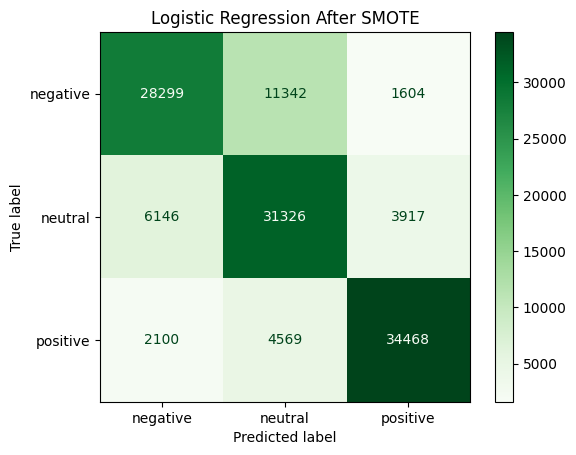

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_, cmap='Greens')
plt.title("Logistic Regression After SMOTE")
plt.show()

In [ ]:
# Saving the Best model
import joblib
joblib.dump(model, 'logistic_regression_model.pkl')


['logistic_regression_model.pkl']

In [ ]:
# Save models and data to Google Drive

from google.colab import drive
drive.mount('/content/drive')

joblib.dump(model, '/content/drive/My Drive/logistic_regression_model.pkl')


Mounted at /content/drive


['/content/drive/My Drive/logistic_regression_model.pkl']

### Comparing Undersampling vs SMOTE

In [33]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

In [34]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['text'])
y = df['label']

In [35]:
df_copy = df.copy()
df_copy['vector'] = list(X)
min_size = df_copy['sentiment'].value_counts().min()

balanced_undersampled = pd.concat([
    resample(df_copy[df_copy['sentiment'] == s], replace=False, n_samples=min_size, random_state=42)
    for s in df_copy['sentiment'].unique()
])

X_under = vectorizer.transform(balanced_undersampled['text'])
y_under = le.transform(balanced_undersampled['sentiment'])


In [36]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)


In [37]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)


In [38]:
# Undersampling model training
model_under = LogisticRegression(max_iter=1000, class_weight='balanced')
model_under.fit(X_train_u, y_train_u)
pred_under = model_under.predict(X_test_u)

In [39]:
print("Undersampling Results:")
print(classification_report(y_test_u, pred_under, target_names=le.classes_))


Undersampling Results:
              precision    recall  f1-score   support

    negative       0.69      0.71      0.70      3860
     neutral       0.60      0.57      0.59      3932
    positive       0.77      0.78      0.77      3873

    accuracy                           0.69     11665
   macro avg       0.68      0.69      0.69     11665
weighted avg       0.68      0.69      0.69     11665



In [40]:
# Oversampling (SMOTE) model training
model_smote = LogisticRegression(max_iter=1000, class_weight='balanced')
model_smote.fit(X_train_s, y_train_s)
pred_smote = model_smote.predict(X_test_s)

In [41]:
print("SMOTE Results:")
print(classification_report(y_test_s, pred_smote, target_names=le.classes_))

SMOTE Results:
              precision    recall  f1-score   support

    negative       0.77      0.69      0.73     41245
     neutral       0.66      0.76      0.71     41389
    positive       0.86      0.84      0.85     41137

    accuracy                           0.76    123771
   macro avg       0.77      0.76      0.76    123771
weighted avg       0.77      0.76      0.76    123771



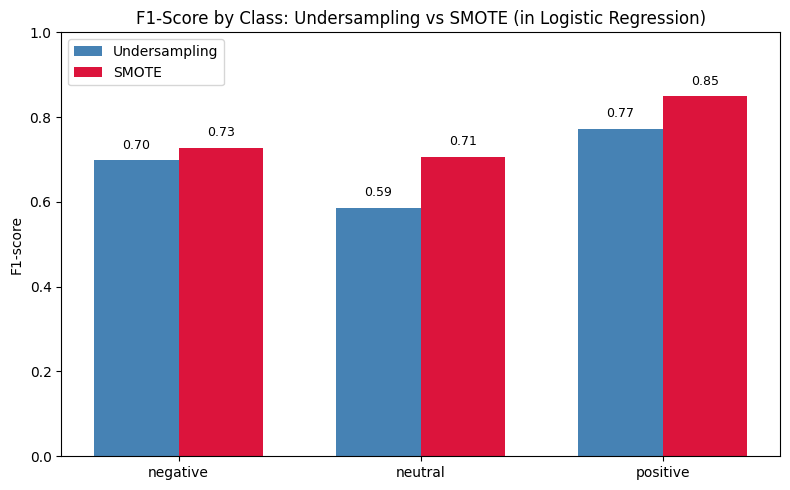

In [44]:
report_under = classification_report(y_test_u, pred_under, target_names=le.classes_, output_dict=True)
report_smote = classification_report(y_test_s, pred_smote, target_names=le.classes_, output_dict=True)

labels = le.classes_
f1_under = [report_under[label]["f1-score"] for label in labels]
f1_smote = [report_smote[label]["f1-score"] for label in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, f1_under, width, label='Undersampling', color='steelblue')
bars2 = ax.bar(x + width/2, f1_smote, width, label='SMOTE', color='crimson')

ax.set_ylabel('F1-score')
ax.set_title('F1-Score by Class: Undersampling vs SMOTE (in Logistic Regression)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()

for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Random Forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))


              precision    recall  f1-score   support

    negative       0.80      0.69      0.74     41245
     neutral       0.69      0.74      0.71     41389
    positive       0.78      0.83      0.80     41137

    accuracy                           0.75    123771
   macro avg       0.76      0.75      0.75    123771
weighted avg       0.76      0.75      0.75    123771



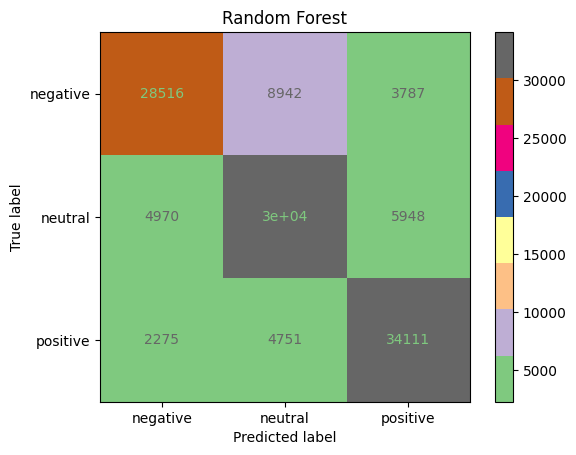

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=le.classes_, cmap='Accent')
plt.title("Random Forest")
plt.show()

## Optimized Random Forest (hyperparameter tuning with RandomizedSearchCV)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_base = RandomForestClassifier(random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_rf.predict(X_test)
print("Best RF Parameters:", rf_search.best_params_)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Best RF Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}

Classification Report:

              precision    recall  f1-score   support

    negative       0.74      0.64      0.69     41257
     neutral       0.64      0.67      0.65     41257
    positive       0.74      0.82      0.78     41257

    accuracy                           0.71    123771
   macro avg       0.71      0.71      0.71    123771
weighted avg       0.71      0.71      0.71    123771



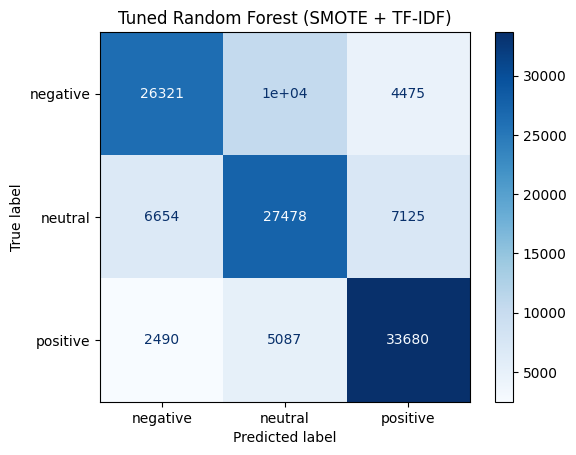

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_, cmap='Blues')
plt.title("Tuned Random Forest (SMOTE + TF-IDF)")
plt.show()

## Tuned XG BOOST

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

param_dist_xgb = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    tree_method='hist',
    random_state=42
)

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=2,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [ ]:
y_pred = best_xgb.predict(X_test)

print("Best XGBoost Parameters:", xgb_search.best_params_)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Classification Report:

              precision    recall  f1-score   support

    negative       0.66      0.65      0.66     41257
     neutral       0.59      0.65      0.62     41257
    positive       0.78      0.73      0.76     41257

    accuracy                           0.67    123771
   macro avg       0.68      0.67      0.68    123771
weighted avg       0.68      0.67      0.68    123771



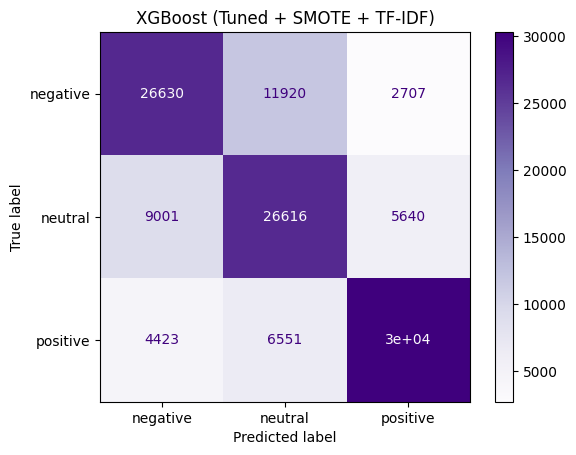

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_, cmap='Purples')
plt.title("XGBoost (Tuned + SMOTE + TF-IDF)")
plt.show()

### **SVM**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import MaxAbsScaler


scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = LinearSVC(C=1.0, max_iter=1000, random_state=42)
calibrated_svc = CalibratedClassifierCV(svc, method="sigmoid")
calibrated_svc.fit(X_train_scaled, y_train)

y_pred_svc = calibrated_svc.predict(X_test_scaled)


In [ ]:
print("Classification Report (SVM):\n")
print(classification_report(y_test, y_pred_svc, target_names=le.classes_))


Classification Report (SVM):

              precision    recall  f1-score   support

    negative       0.77      0.69      0.73     41257
     neutral       0.67      0.76      0.71     41257
    positive       0.86      0.85      0.85     41257

    accuracy                           0.76    123771
   macro avg       0.77      0.76      0.77    123771
weighted avg       0.77      0.76      0.77    123771



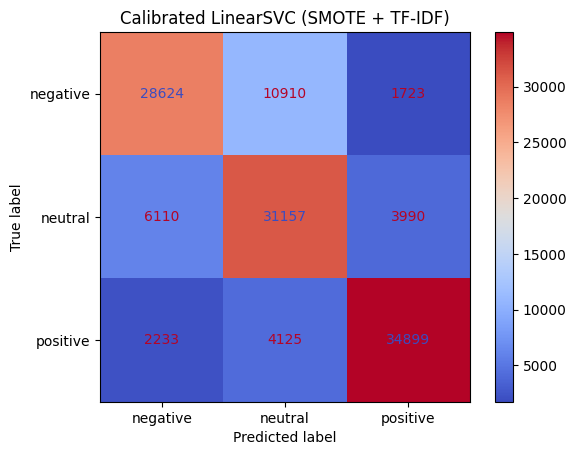

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc, display_labels=le.classes_, cmap='coolwarm')
plt.title("Calibrated LinearSVC (SMOTE + TF-IDF)")
plt.show()

### **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB


vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_vectorized = vectorizer.fit_transform(df['text'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(df['sentiment'])

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)




In [ ]:
print("Classification Report (Naive Bayes):\n")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

Classification Report (Naive Bayes):

              precision    recall  f1-score   support

    negative       0.72      0.71      0.71     41245
     neutral       0.61      0.65      0.63     41389
    positive       0.80      0.77      0.78     41137

    accuracy                           0.71    123771
   macro avg       0.71      0.71      0.71    123771
weighted avg       0.71      0.71      0.71    123771



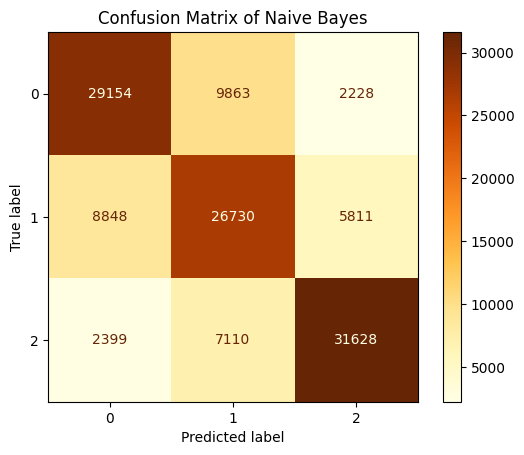

In [ ]:
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.YlOrBr)
plt.title("Confusion Matrix of Naive Bayes")
plt.show()

### **ROC-AUC Curve For All Models**


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

def plot_roc_curve(y_test, y_pred_proba, model_name, classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, class_label in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == class_label, y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test == class_label, y_pred_proba[:, i])

    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {class_label} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

classes = [0, 1, 2]


#### **1. Logistic Regression ROC curve**

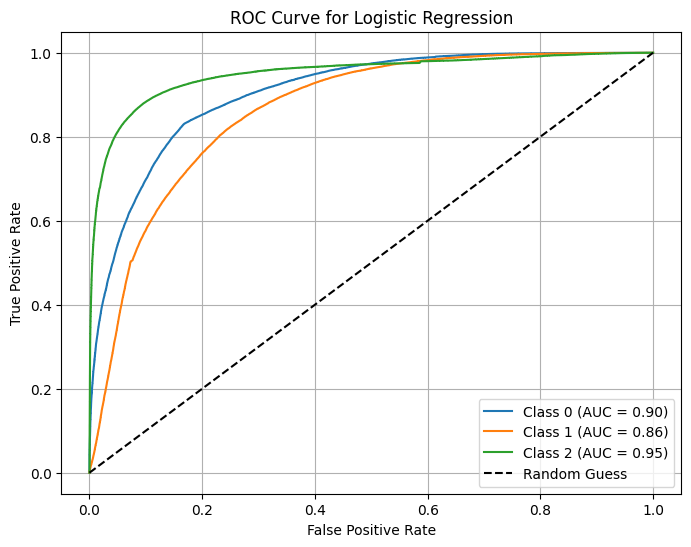

In [ ]:
# Logistic Regression ROC
y_pred_proba_lr = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_proba_lr, "Logistic Regression", classes)

#### **2. Random Forest ROC curve**


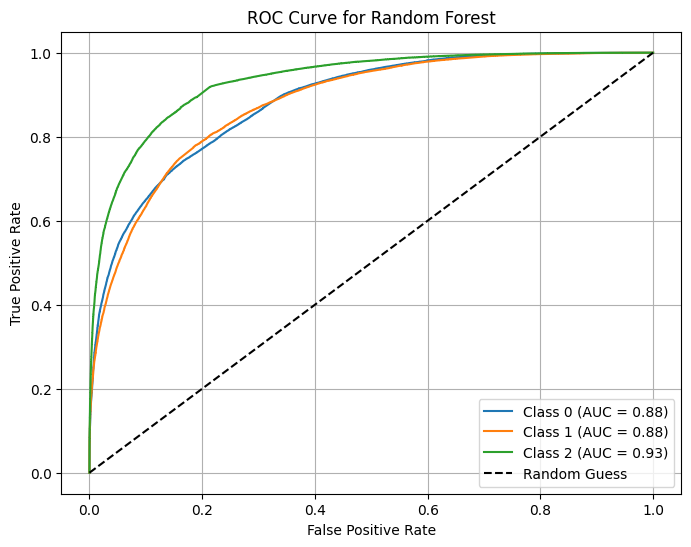

In [ ]:
y_pred_proba_rf = rf_model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_proba_rf, "Random Forest", classes)

#### **3. SVM ROC curve**


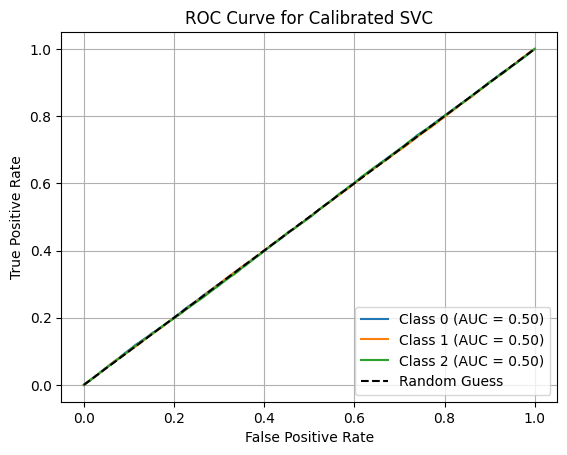

In [ ]:
plot_roc_curve(y_test, y_pred_proba_svm, "Calibrated SVC", class_labels=le.transform(le.classes_))


#### **4. Naive Bayes ROC curve**

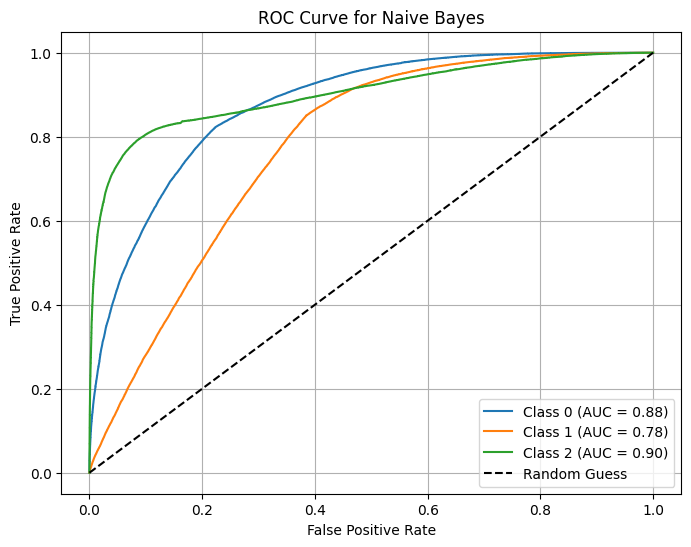

In [ ]:
y_pred_proba_nb = nb_model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_proba_nb, "Naive Bayes", classes)

## Cross- Validation For All Models

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "SVM (Linear)": LinearSVC(class_weight='balanced', max_iter=1000),
    "Naive Bayes": MultinomialNB()
}

results = []

for name, model in models.items():
    print(f"Running CV for: {name}")
    scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1_macro')
    results.append({
        'Model': name,
        'F1 Macro Mean': scores.mean(),
        'F1 Macro Std': scores.std()
    })

cv_results_df = pd.DataFrame(results).sort_values(by='F1 Macro Mean', ascending=False)


Running CV for: Logistic Regression
Running CV for: Random Forest
Running CV for: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:56:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:21:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:34:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:47:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Running CV for: SVM (Linear)
Running CV for: Naive Bayes


In [ ]:
print(cv_results_df)


                 Model  F1 Macro Mean  F1 Macro Std
0  Logistic Regression       0.760189      0.007551
3         SVM (Linear)       0.757056      0.004744
1        Random Forest       0.746565      0.018517
2              XGBoost       0.732688      0.019880
4          Naive Bayes       0.706013      0.004343


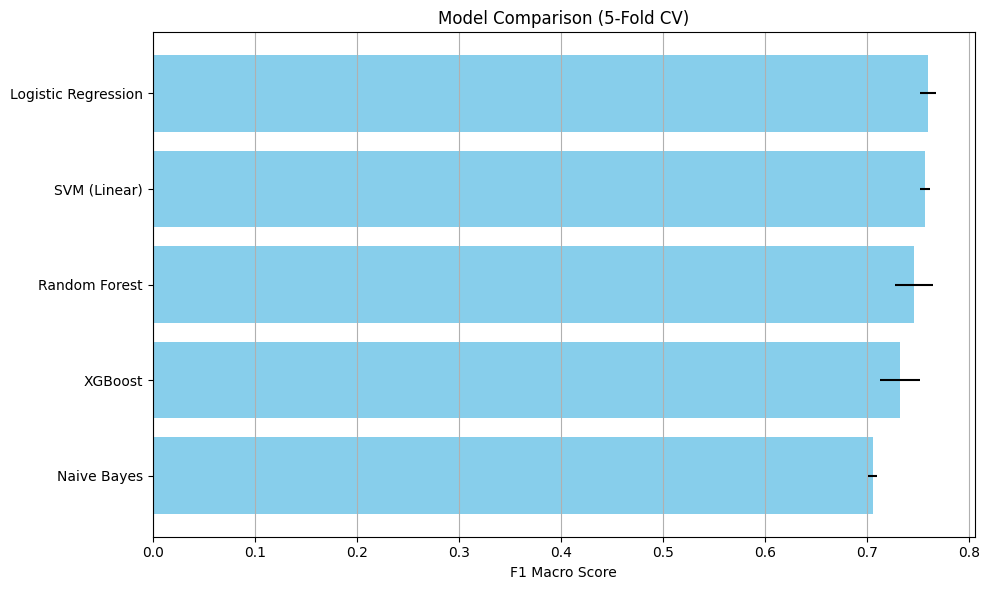

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(cv_results_df['Model'], cv_results_df['F1 Macro Mean'], xerr=cv_results_df['F1 Macro Std'], color='skyblue')
plt.xlabel('F1 Macro Score')
plt.title('Model Comparison (5-Fold CV)')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### **Conclusion**
The coursework delve into training and evaluation of unbalanced and balanced dataset with different vectorization techniques. It shows how the dataset can impact the evalaution of the model.

Following key insights can be derived from the above evaluation from classification report and ROC curve

Overall Strengths:  All three models perform similarly for class 2 (AUC = 0.93), indicating excellent classification for positive sentiments.
Neutral Sentiments Challenge: All models struggle with class 1, with Logistic Regression (AUC = 0.83) slightly outperforming Logistic Regression and SVM (AUC = 0.82).
For Negative Sentiments: Logistic Regression and SVM (AUC = 0.89) performs slightly better for class 0.

**Logistic Regression is the best overall model** due to its superior performance for positive sentiments (class 2) and comparable results for the other classes.